In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import os, re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

from tqdm import tqdm



In [2]:
import warnings
warnings.filterwarnings("ignore")

cosine sim for all datapoints

In [3]:
# # Assuming tfidf_matrix and the combined_data dataframe are already defined from the previous steps

# # Compute Cosine Similarity
# cosine_sim = cosine_similarity(tfidf_matrix)

# # Create a DataFrame for the cosine similarity matrix
# cosine_sim_df = pd.DataFrame(cosine_sim, cluster=combined_data['role'], columns=combined_data['role'])

# # Display the cosine similarity matrix
# print("Cosine Similarity Matrix:")
# cosine_sim_df


avg cosine sim between each query (role)

In [4]:
def calculate_average_cosine_sim(tfidf_df: pd.DataFrame):
    roles = pd.unique(tfidf_df['role'])

    # Extracting TF-IDF features for each role
    role_tfidf_matrices = [tfidf_df[tfidf_df['role'] == role].drop('role', axis=1) for role in roles]

    # Initialize a matrix to store average cosine similarities
    average_cosine_sim = pd.DataFrame(cluster=roles, columns=roles, dtype=float)
    
    print([a.shape for a in role_tfidf_matrices])

    for i, role_i in enumerate(roles):
        for j, role_j in enumerate(roles):
            print(role_i,role_j)
            cosine_sim_ij = cosine_similarity(role_tfidf_matrices[i], role_tfidf_matrices[j])
            if i == j:
                # Exclude the diagonal (self-similarities) before averaging
                np.fill_diagonal(cosine_sim_ij, np.nan)
                average = np.nanmean(cosine_sim_ij)
            else:
                average = cosine_sim_ij.mean()
            average_cosine_sim.iloc[i, j] = average
            average_cosine_sim.iloc[j, i] = average  # Symmetric matrix

    return average_cosine_sim

In [35]:
import time

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

def test_clusters_agglomerative(tfidf_matrix, strategy, cluster_range, Z=None):
    """
    Test and plot metrics for agglomerative clustering for up to max_clusters.

    :param tfidf_matrix: TF-IDF matrix of the text data.
    :param strategy: Linkage criterion for Agglomerative Clustering ('ward', 'average', 'complete').
    :param max_clusters: Maximum number of clusters to test (default is 10).
    """
    # Perform Agglomerative Clustering
    if Z is None:
        # Timing the linkage execution
        start_time = time.time()
        if isinstance(tfidf_matrix, np.ndarray):
            Z = linkage(tfidf_matrix, method=strategy)
        else:
            Z = linkage(tfidf_matrix.toarray(), method=strategy)
        end_time = time.time()
        print(f"linkage executed in {(end_time - start_time):.2f} seconds")
        
    # Initialize lists to store metrics
    silhouette_scores_agg = []
    davies_bouldin_scores_agg = []

    for n_clusters in tqdm(cluster_range,total=len(cluster_range)):
        # Extracting labels for n clusters from the dendrogram
        labels = fcluster(Z, n_clusters, criterion='maxclust')
        
        # Silhouette Score
        silhouette_avg = silhouette_score(tfidf_matrix, labels, random_state=123)
        silhouette_scores_agg.append(silhouette_avg)
        
        # Davies-Bouldin Score
        db_score = davies_bouldin_score(tfidf_matrix, labels)
        davies_bouldin_scores_agg.append(db_score)

    # Plotting the metrics
    plt.figure(figsize=(10, 5))

    # Plot Silhouette Scores
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, silhouette_scores_agg, marker='o')
    plt.title(f'Silhouette Scores vs. Number of Clusters ({strategy})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    # Plot Davies-Bouldin Scores
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, davies_bouldin_scores_agg, marker='o')
    plt.title(f'Davies-Bouldin Scores vs. Number of Clusters ({strategy})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame.from_dict({'n_clusters':cluster_range, 'silhouette':silhouette_scores_agg, 'davies_bouldin':davies_bouldin_scores_agg}) 

In [6]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html


def get_cluster_labels_agglomerative(tfidf_matrix, strategy, n_clusters, Z=None):
    """
    Perform Agglomerative Clustering on the given TF-IDF matrix, plot the dendrogram,
    and return the cluster labels.

    :param tfidf_matrix: TF-IDF matrix after dimensionality reduction to 25 components.
    :param strategy: Linkage criterion for Agglomerative Clustering.
    :param n_clusters: The number of clusters to form.
    :return: Cluster labels.
    """
    # assert tfidf_matrix.shape[1] == 25  # Ensure we have 25 components

    if Z is None:
        # Timing the linkage execution
        start_time = time.time()
        if isinstance(tfidf_matrix, np.ndarray):
            Z = linkage(tfidf_matrix, method=strategy)
        else:
            Z = linkage(tfidf_matrix.toarray(), method=strategy)
        end_time = time.time()
        print(f"linkage executed in {(end_time - start_time):.2f} seconds")

    # Plotting the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=n_clusters,  # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  # to get a distribution impression in truncated branches
    )
    plt.title(f'Dendrogram for Agglomerative Clustering with {strategy} linkage')
    plt.xlabel('Cluster size')
    plt.ylabel('Distance')
    plt.show()

    # Extracting labels for n clusters from the dendrogram
    labels = fcluster(Z, n_clusters, criterion='maxclust')

    silhouette_avg = silhouette_score(tfidf_matrix, labels, random_state=123)
    db_score = davies_bouldin_score(tfidf_matrix, labels)
    
    print(silhouette_avg, db_score)
    print(pd.Series(labels).value_counts())
    
    return labels, silhouette_avg, db_score

In [7]:
def plot_and_save_dendrograms(tfidf_matrix, strategy, cluster_range, save_dir, Z=None):
    """
    Perform linkage once, loop through a range of cluster numbers, and save dendrogram plots with figsize proportional to n_clusters.

    :param tfidf_matrix: TF-IDF matrix after dimensionality reduction.
    :param strategy: Linkage criterion for Agglomerative Clustering.
    :param cluster_range: Range of cluster numbers to plot dendrograms for.
    :param save_dir: Directory to save the dendrogram plots.
    """
    # Create the directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Perform linkage
    if Z is None:
        # Timing the linkage execution
        start_time = time.time()
        if isinstance(tfidf_matrix, np.ndarray):
            Z = linkage(tfidf_matrix, method=strategy)
        else:
            Z = linkage(tfidf_matrix.toarray(), method=strategy)
        end_time = time.time()
        print(f"linkage executed in {(end_time - start_time):.2f} seconds")

    for n_clusters in tqdm(cluster_range, total=len(cluster_range)):
        # Adjusting figure size based on the number of clusters
        fig_width = max(10, 1.21*(n_clusters / 3))
        fig_height = max(7, 1.21*(n_clusters / 4))

        plt.figure(figsize=(fig_width, fig_height))
        dendrogram(
            Z,
            truncate_mode='lastp',  # to improve readability
            p=n_clusters,  # show only the last p merged clusters
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
        )
        plt.title(f'Dendrogram for {n_clusters} Clusters with {strategy} Linkage')
        plt.xlabel('Cluster size')
        plt.ylabel('Distance')

        # Save the plot
        plt.savefig(f'{save_dir}/dendrogram_{n_clusters}_clusters.png', dpi=300)
        plt.close()


In [8]:
def remove_duplicates(df:pd.DataFrame, exclude=None):
    subset_columns = ['Job Title', 'Company Name', 'Location', 'Salary Estimate', 'Rating', 'Job Description']
    if exclude:
        if isinstance(exclude, list):
            subset_columns = [a for a in subset_columns if a not in exclude]
        else:
            subset_columns.remove(exclude)
    
    df.sort_values(subset_columns, inplace=True)

    df['Duplicate Count'] = df.groupby(subset_columns)['Job Title'].transform('count')
    print(df['Duplicate Count'].value_counts())
    df.drop_duplicates(subset=subset_columns, inplace=True, keep='last')
    df.reset_index(drop=True,inplace=True)
    

In [9]:

df_business_analyst = pd.read_csv('data_jobs_data/data/BusinessAnalyst clean.csv')
df_data_analyst = pd.read_csv('data_jobs_data/data/DataAnalyst clean.csv')
df_data_engineer = pd.read_csv('data_jobs_data/data/DataEngineer clean.csv')
df_data_scientist = pd.read_csv('data_jobs_data/data/DataScientist clean.csv')

# Combine data for TF-IDF analysis
combined_data = pd.concat([
    df_business_analyst.assign(role="Business Analyst"),
    df_data_analyst.assign(role="Data Analyst"),
    df_data_scientist.assign(role="Data Scientist"),
    df_data_engineer.assign(role="Data Engineer"),
])
# print(combined_data.role.value_counts())
# combined_data
remove_duplicates(combined_data, exclude=['Location','Salary Estimate']) # sometimes salary is location-dependent. we are only analyzing job descriptions so this is fine.
print(combined_data.role.value_counts())

# Job Title,Company Name,Location,Salary Estimate,Rating,Job Description,Founded,Industry,Revenue,Sector,Size,Type,Easy Apply,Duplicate Count,
# Job Title clean,Salary Type,min_salary,max_salary,job_description_cleaned,Years Experience

combined_data

Duplicate Count
1.0     10704
2.0      2288
3.0       990
4.0       192
5.0        75
8.0        56
6.0        54
47.0       47
7.0        42
26.0       26
11.0       22
9.0        18
15.0       15
14.0       14
10.0       10
Name: count, dtype: int64
role
Data Analyst        4691
Business Analyst    3485
Data Scientist      3114
Data Engineer       2322
Name: count, dtype: int64


,Job Title,Company Name,Location,Salary Estimate,Rating,Job Description,Founded,Industry,Revenue,Sector,...,Easy Apply,Duplicate Count,Salary Type,min_salary,max_salary,State,job_description_cleaned,Job Title clean,Years Experience,role
0,!!!100% Remote!!! Sr. Data and Integration Eng...,Amerit Consulting,"Dallas, TX",74-134,3.5,Job Description\nOur client is an American for...,2002.0,State & Regional Agencies,$5 to $10 million (USD),Government,...,False,1.0,Annual (K),74.0,134.0,TX,job description our client is an american for ...,remote senior data and integration engineer,NaN,Data Engineer
1,"""Business Analyst/ Data Analyst with experienc...",ESolutions Inc,"Tampa, FL",62-113,4.0,Job Title: Business Analyst/ Data Analyst with...,1999.0,IT Services,$50 to $100 million (USD),Information Technology,...,False,1.0,Annual (K),62.0,113.0,FL,job title business analyst data analyst with e...,business analyst data analyst experience on an...,NaN,Data Analyst
2,#104252 Division Data and Financial Analyst,UC San Diego,"San Diego, CA",34-61,4.3,This position will remain open until filled.\n...,1960.0,Colleges & Universities,NaN,Education,...,False,1.0,Annual (K),34.0,61.0,CA,this position will remain open until filled uc...,division data and financial analyst,NaN,Data Analyst
3,#104293 Business Tech Support Analyst,UC San Diego,"San Diego, CA",31-61,4.3,UCSD Layoff from Career Appointment: Apply by ...,1960.0,Colleges & Universities,NaN,Education,...,False,1.0,Annual (K),31.0,61.0,CA,ucsd layoff from career appointment apply by f...,business tech support analyst,NaN,Business Analyst
4,#104733 HPC Systems and Data Engineer,UC San Diego,"San Diego, CA",46-92,4.3,The effects of the COVID-19 pandemic have impa...,1960.0,Colleges & Universities,NaN,Education,...,False,2.0,Annual (K),46.0,92.0,CA,the effect of the covid pandemic have impacted...,hpc system and data engineer,NaN,Data Engineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607,senior data systems analyst,Citi,Texas,-1,3.7,Position Summary: The Senior Data Systems anal...,1812.0,Investment Banking & Asset Management,$10+ billion (USD),Finance,...,False,1.0,Annual (K),NaN,NaN,TX,position summary the senior data system analys...,senior data system analyst,14,Data Analyst
13608,senior data systems analyst,Citibank,Texas,85-153,3.8,Position Summary: The Senior Data Systems anal...,NaN,Lending,NaN,Finance,...,False,1.0,Annual (K),85.0,153.0,TX,position summary the senior data system analys...,senior data system analyst,14,Data Analyst
13609,systems Analyst 1596 (d),The City of Los Angeles,"Los Angeles, CA",48-100,3.6,"DUTIESANNUAL SALARY$70,156 to $102,562The sala...",NaN,Municipal Governments,NaN,Government,...,False,1.0,Annual (K),48.0,100.0,CA,dutiesannual salary to salary in the departmen...,system analyst,NaN,Business Analyst
13610,"{""title"":""GAO Analyst (Data Analysis)"",""extend...",Legislative Branch,"Washington, DC",61-108,4.3,DutiesHelpDutiesSummaryThis position is locate...,1789.0,State & Regional Agencies,NaN,Government,...,False,3.0,Annual (K),61.0,108.0,NaN,dutieshelpdutiessummarythis position is locate...,title gao analyst extended opening_type null,NaN,Data Analyst


In [44]:

# def convert_matrix_to_df(mat, feature_names):
#     if not isinstance(mat, np.ndarray):
#         mat = mat.toarray()
#     df = pd.DataFrame(mat, columns=feature_names)
#     return df


def filter_top_n_features(count_mat, vectorizer, n):
    # Efficiently summing up the counts and getting the top n features
    sum_words = np.array(count_mat.sum(axis=0)).ravel()
    top_n_indices = np.argsort(sum_words)[::-1][:n]
    feature_names = np.array(vectorizer.get_feature_names_out())[top_n_indices]
    filtered_count_mat = count_mat[:, top_n_indices]
    return filtered_count_mat, feature_names

def get_count_and_tfidf_dfs(df, column, count_vectorizer, top_n=None):
    print(column, count_vectorizer.ngram_range)
    count_mat = count_vectorizer.fit_transform(df[column].fillna(''))
    print(count_mat.shape)
    
    if top_n is not None and top_n < count_mat.shape[1]:
        print("Original count matrix shape:", count_mat.shape)
        count_mat, feature_names = filter_top_n_features(count_mat, count_vectorizer, top_n)
        print("Filtered count matrix shape:", count_mat.shape)
    else:
        feature_names = count_vectorizer.get_feature_names_out()
    
    tfidf_transformer = TfidfTransformer()
    tfidf_mat = tfidf_transformer.fit_transform(count_mat)

    return count_mat, tfidf_mat, feature_names

def compute_cluster_means(sparse_mat, cluster_assignments):
    unique_clusters = np.unique(cluster_assignments)
    means = {}

    for cluster in unique_clusters:
        cluster_rows = sparse_mat[cluster_assignments == cluster]
        cluster_mean = np.array(cluster_rows.mean(axis=0)).flatten()
        means[cluster] = cluster_mean
    return means

def search_keywords(feats, patterns, n, regex):
    ids = []
    for i, f in enumerate(feats):
        if regex:
            if any(regex.search(f) for regex in patterns):
                ids.append(i)
        else:
            if any(keyword in f for keyword in patterns):
                ids.append(i)
        if len(ids) == n:
            break
    return np.array(ids)

def get_feats_helper(feats, vals, ids, n):
    if len(ids) == 0:
        feats_ = ['no keywords found']+list(range(n-1))
        vals_ = [0]*n
    else:
        feats_ = feats[ids]
        vals_ = vals[ids]
    return feats_, vals_

def plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, top_n_for_graph, top_n_for_sheet, save_dir, cluster_assignments=None, keywords=None, regex=True):
    # Add cluster assignments if provided
    if cluster_assignments is None:
        cluster_assignments = list(np.zeros((count_mat.shape[0],), dtype=int))

    tfidf_means = compute_cluster_means(tfidf_mat, cluster_assignments)
    count_means = compute_cluster_means(count_mat, cluster_assignments)
    
    if keywords is not None and regex:
        regex_patterns = [re.compile(r'\b' + re.escape(kw) + r'\b') for kw in keywords]
            
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    dataframes = []
        
    # Visualizing the top top_n_for_graph keywords for each role (and cluster if applicable)
    for cluster in tfidf_means:
        size = (cluster_assignments == cluster).sum()
        plt.figure(figsize=(12, 8*(top_n_for_graph/10)))
        plt.tight_layout()

        top_tfidf_indices = np.argsort(-tfidf_means[cluster])
        top_tfidf_values = -np.sort(-tfidf_means[cluster])
        top_tfidf_features = feature_names[top_tfidf_indices].flatten()
        top_count_indices = np.argsort(-count_means[cluster])
        top_count_values = -np.sort(-count_means[cluster])
        top_count_features = feature_names[top_count_indices].flatten()

        if keywords is not None:
            ids = search_keywords(top_tfidf_features, regex_patterns if regex else keywords, top_n_for_graph, regex)
            top_tfidf_features_, top_tfidf_values_ = get_feats_helper(top_tfidf_features, top_tfidf_values, ids, top_n_for_graph)
            ids = search_keywords(top_count_features, regex_patterns if regex else keywords, top_n_for_graph, regex)
            top_count_features_, top_count_values_ = get_feats_helper(top_count_features, top_count_values, ids, top_n_for_graph)
        else:
            top_tfidf_features_, top_tfidf_values_ = top_tfidf_features, top_tfidf_values
            top_count_features_, top_count_values_ = top_count_features, top_count_values
            
        # Plotting TF-IDF
        ax1 = plt.subplot(2, 1, 1)
        sns.barplot(x=top_tfidf_values_[:top_n_for_graph], y=top_tfidf_features_[:top_n_for_graph], ax=ax1)
        ax1.set_xlabel('TF-IDF Score')
        ax1.set_ylabel('Tokens')
        ax1.set_yticklabels(top_tfidf_features_[:top_n_for_graph], rotation=0)

        # Plotting Count Vectorizer
        ax2 = plt.subplot(2, 1, 2)
        sns.barplot(x=top_count_values_[:top_n_for_graph], y=top_count_features_[:top_n_for_graph], ax=ax2)
        ax2.set_xlabel('Word Frequency')
        ax2.set_ylabel('Tokens')
        ax2.set_yticklabels(top_count_features_[:top_n_for_graph], rotation=0)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92,left=0.5)  # Reserve 50% of the figure's width for labels
        
        if keywords is not None:
            ids = search_keywords(top_tfidf_features, regex_patterns if regex else keywords, top_n_for_sheet, regex)
            top_tfidf_features_, top_tfidf_values_ = get_feats_helper(top_tfidf_features, top_tfidf_values, ids, top_n_for_sheet)
            ids = search_keywords(top_count_features, regex_patterns if regex else keywords, top_n_for_sheet, regex)
            top_count_features_, top_count_values_ = get_feats_helper(top_count_features, top_count_values, ids, top_n_for_sheet)
        else:
            top_tfidf_features_, top_tfidf_values_ = top_tfidf_features, top_tfidf_values
            top_count_features_, top_count_values_ = top_count_features, top_count_values

        merged = pd.DataFrame({'token_tfidf': top_tfidf_features_[:top_n_for_sheet], 'tfidf': top_tfidf_values_[:top_n_for_sheet],
                            'token_wordfreq': top_count_features_[:top_n_for_sheet], 'wordfreq': top_count_values_[:top_n_for_sheet]})
        merged['cluster_assignment'] = cluster
        merged['cluster_size'] = size
        dataframes.append(merged)

        # Save the plot
        if len(set(cluster_assignments)) != 1:
            plt.suptitle(f"{column}: Comparison of Top {top_n_for_graph} Keywords for Cluster {cluster} ({size} docs)\n")
            plt.savefig(f'{save_dir}/top_{top_n_for_graph}_keywords_cluster_{cluster}.png', dpi=300)
        else:
            plt.suptitle(f"{column}: Comparison of Top {top_n_for_graph} Keywords ({size} docs)")
            plt.savefig(f'{save_dir}/top_{top_n_for_graph}_keywords.png', dpi=300)
        plt.close()
        
    sheet = pd.concat(dataframes, ignore_index=True)
    sheet = sheet[['cluster_assignment', 'cluster_size', 'token_wordfreq', 'wordfreq', 'token_tfidf', 'tfidf']]
    if len(set(cluster_assignments)) != 1:
        sheet.to_csv(f'{save_dir}/top_{top_n_for_sheet}_keywords_per_cluster.csv', index=False)
    else:
        sheet.drop('cluster_assignment',axis=1).to_csv(f'{save_dir}/top_{top_n_for_sheet}_keywords.csv', index=False)

In [11]:
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

def train_word2vec(corpus, size=100, window=5, min_count=5, workers=4):
    """
    Train a Word2Vec model on the provided corpus.

    :param corpus: List of tokenized job descriptions.
    :param size: The number of dimensions of the embeddings.
    :param window: The maximum distance between the current and predicted word.
    :param min_count: Ignores all words with total frequency lower than this.
    :param workers: Use these many worker threads to train the model.
    :return: Trained Word2Vec model.
    """
    model = Word2Vec(corpus, vector_size=size, window=window, min_count=min_count, workers=workers)
    model.train(corpus, total_examples=len(corpus), epochs=10)
    return model

def get_document_vectors(w2v_model, corpus):
    """
    Get vector representations for documents by averaging word vectors.

    :param w2v_model: Trained Word2Vec model.
    :param corpus: List of tokenized job descriptions.
    :return: Numpy array of document vectors.
    """
    document_vectors = []
    for doc in corpus:
        vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
        if vectors:
            document_vectors.append(np.mean(vectors, axis=0))
        else:
            # Handle case for documents without any words in model vocabulary
            document_vectors.append(np.zeros(w2v_model.vector_size))
    return np.array(document_vectors)

def cluster_documents(document_vectors, n_clusters):
    """
    Cluster the document vectors and evaluate with silhouette and Davies-Bouldin scores.

    :param document_vectors: Numpy array of document vectors.
    :param n_clusters: The number of clusters to form.
    :return: Cluster labels, silhouette score, and Davies-Bouldin score.
    """
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
    labels = clustering_model.fit_predict(document_vectors)

    silhouette_avg = silhouette_score(document_vectors, labels)
    db_score = davies_bouldin_score(document_vectors, labels)

    return labels, silhouette_avg, db_score


In [12]:
ng = (1,1)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=ng)
tfidf_matrix = vectorizer.fit_transform(combined_data['job_description_cleaned'])
# Create a DataFrame with TF-IDF scores
feature_names = vectorizer.get_feature_names_out()

# tfidf_df = convert_matrix_to_df(tfidf_matrix, vectorizer.get_feature_names_out())
# tfidf_df['role'] = combined_data['role'].values


print(tfidf_matrix.shape)

(13612, 42849)


In [13]:


# 2 min


max_components = 400
window = 5

tokenized_corpus = [doc.split() for doc in combined_data['job_description_cleaned']]

import pickle

if os.path.exists(f'word2vec tfidf {window}/document_embeddings_{max_components}.pkl') and os.path.exists(f'word2vec tfidf {window}/w2v_model_{max_components}.pkl'):
    # To load the matrix from the file later
    with open(f'word2vec tfidf {window}/document_embeddings_{max_components}.pkl', 'rb') as file:
        # doc_vectors = pickle.load(file)
        document_embeddings = pickle.load(file)
        
    with open(f'word2vec tfidf {window}/w2v_model_{max_components}.pkl', 'rb') as file:
        w2v_model = pickle.load(file)
        
    # doc_vectors = get_document_vectors(w2v_model, tokenized_corpus)
    
else:
    os.mkdir(f'word2vec tfidf {window}')
    w2v_model = train_word2vec(tokenized_corpus, size=max_components, window=window, workers=6)
    # doc_vectors = get_document_vectors(w2v_model, tokenized_corpus)

    avg_tfidf_scores = np.mean(tfidf_matrix, axis=0)
    avg_tfidf_scores = np.array(avg_tfidf_scores).flatten()
    tfidf_scores = dict(zip(feature_names, avg_tfidf_scores))
    
    # Compute TF-IDF weighted average of word embeddings for each document
    document_embeddings = np.zeros((len(tokenized_corpus), w2v_model.vector_size))

    for i, doc in enumerate(tokenized_corpus):
        words = doc
        doc_embedding = np.zeros((w2v_model.vector_size,))
        weight_sum = 0
        
        for word in words:
            if word in w2v_model.wv and word in tfidf_scores:
                word_embedding = w2v_model.wv[word]
                tfidf_weight = tfidf_scores[word]
                doc_embedding += word_embedding * tfidf_weight
                weight_sum += tfidf_weight

        if weight_sum > 0:
            doc_embedding /= weight_sum
        
        document_embeddings[i] = doc_embedding


    with open(f'word2vec tfidf {window}/document_embeddings_{max_components}.pkl', 'wb') as file:
        # pickle.dump(doc_vectors, file)
        pickle.dump(document_embeddings, file)
    with open(f'word2vec tfidf {window}/w2v_model_{max_components}.pkl', 'wb') as file:
        pickle.dump(w2v_model, file)
        



In [14]:
document_embeddings.shape

(13612, 400)

In [15]:
print(pd.DataFrame(pd.Series(np.ravel(document_embeddings)).describe()).drop('count').T)

       mean       std       min       25%       50%       75%       max
0  0.033225  0.386529 -2.213081 -0.218173  0.040329  0.299587  2.443667


<Axes: ylabel='Count'>

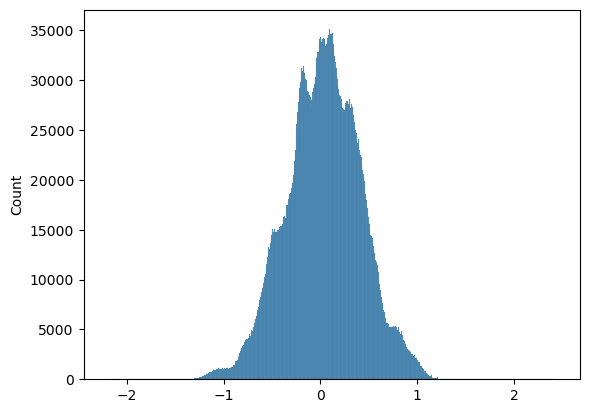

In [16]:
sns.histplot(np.ravel(document_embeddings))

# Agglomerative clustering

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

single, complete, average, ward

In [17]:
max_clusters = 30
interval = 1

cluster_range = list(range(2, max_clusters + 1, interval))
# cluster_range = list(range(20, 80 + 1, 10))
# cluster_range_2 = [5,10,15] + list(range(20, 80 + 1, 10))
print(cluster_range)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [18]:
from scipy.cluster.hierarchy import linkage
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import normalize

def create_linkage_matrix(document_vectors, strategy, norm=None):
    """
    Create a linkage matrix from document vectors using the specified strategy.
    
    :param document_vectors: Numpy array of document vectors.
    :param strategy: Linkage criterion for Agglomerative Clustering.
    :return: Linkage matrix Z.
    """
    
    if strategy == 'ward':
        # 'ward' uses Euclidean distances directly from the document vectors
        if norm is not None:
            document_vectors = normalize(document_vectors, norm=norm)
        Z = linkage(document_vectors, method=strategy)
        return Z, document_vectors
    else:
        # Other strategies use a distance matrix
        distance_matrix = pairwise_distances(document_vectors, metric='cosine')
        # Convert distance matrix from similarities to dissimilarities
        distance_matrix = 1 - distance_matrix
        if norm is not None:
            distance_matrix = normalize(distance_matrix, norm=norm)
        Z = linkage(distance_matrix, method=strategy)
        return Z, distance_matrix



l2


100%|██████████| 29/29 [03:19<00:00,  6.87s/it]


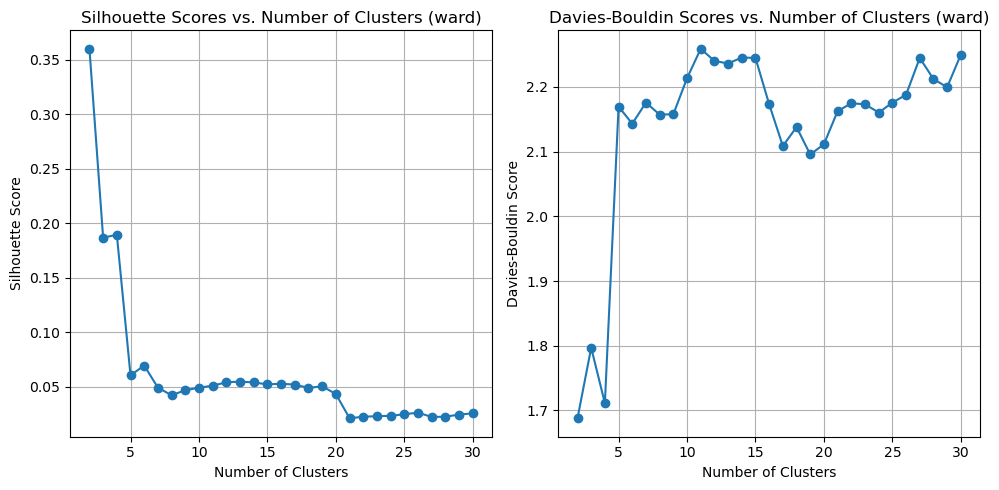

In [36]:
for norm in ['l2']: # 'l1','max',None
    print(norm)
    Z_ward_test, document_embeddings_norm = create_linkage_matrix(document_embeddings, strategy='ward', norm=norm)
    d = test_clusters_agglomerative(document_embeddings_norm, 'ward', cluster_range, Z_ward_test)
    d.to_csv(os.path.join(f'scores vs n_clusters - norm {str(norm or "None")}',f'word2vec tfidf {window}.csv'),index=False)

l1
       mean       std       min       25%       50%       75%       max
0  0.000268  0.003117 -0.011303 -0.001769  0.000328  0.002425  0.012093


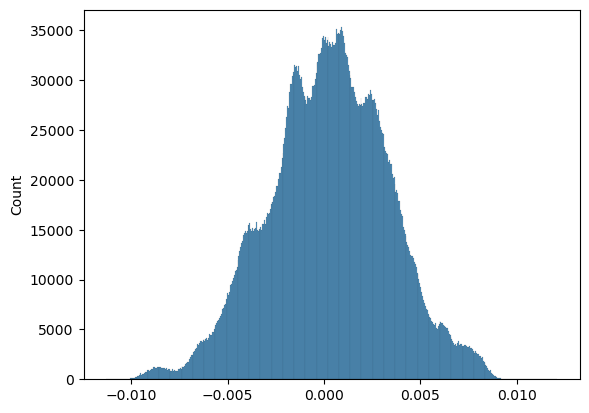

100%|██████████| 29/29 [03:14<00:00,  6.70s/it]


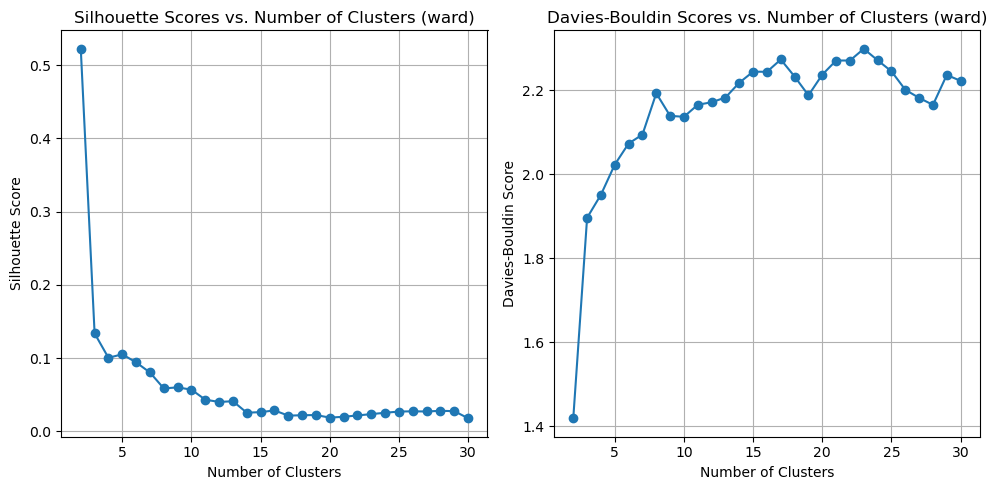

l2
       mean       std       min       25%       50%       75%       max
0  0.004289  0.049814 -0.179145 -0.028269  0.005247  0.038757  0.191405


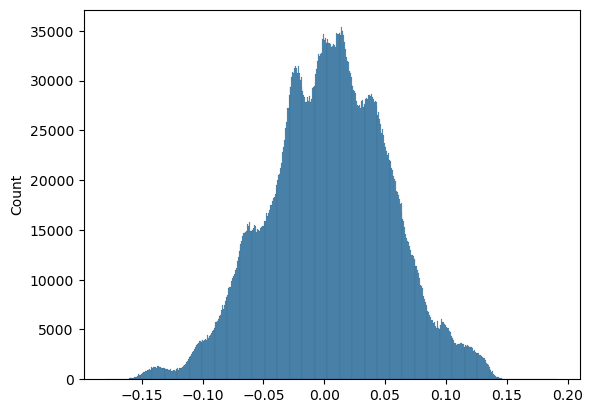

100%|██████████| 29/29 [02:25<00:00,  5.01s/it]


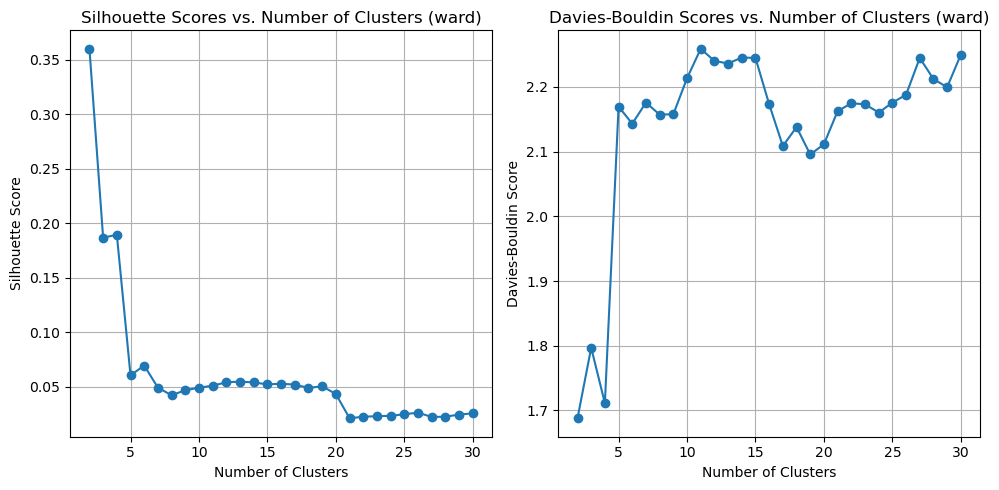

max
      mean       std  min      25%       50%       75%  max
0  0.02936  0.342137 -1.0 -0.19353  0.035929  0.265027  1.0


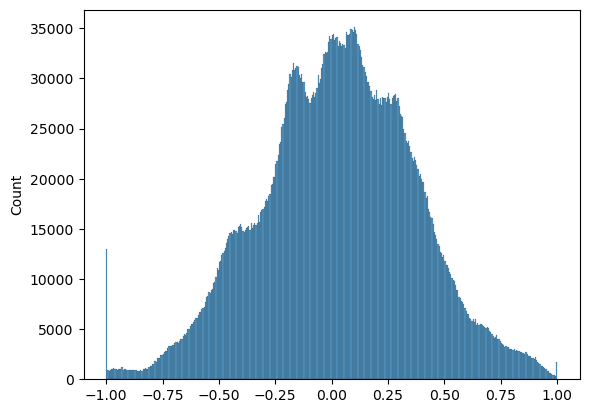

100%|██████████| 29/29 [02:09<00:00,  4.45s/it]


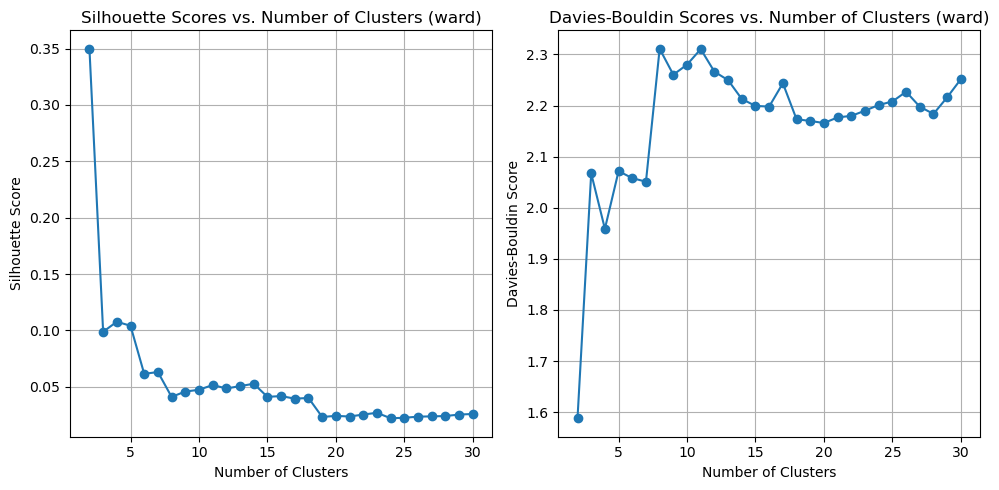

None
       mean       std       min       25%       50%       75%       max
0  0.004289  0.049814 -0.179145 -0.028269  0.005247  0.038757  0.191405


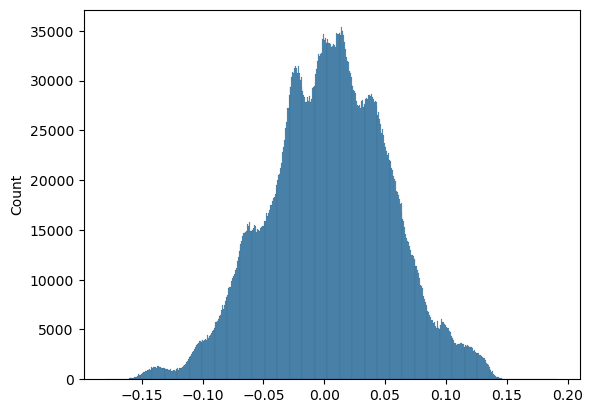

100%|██████████| 29/29 [02:14<00:00,  4.64s/it]


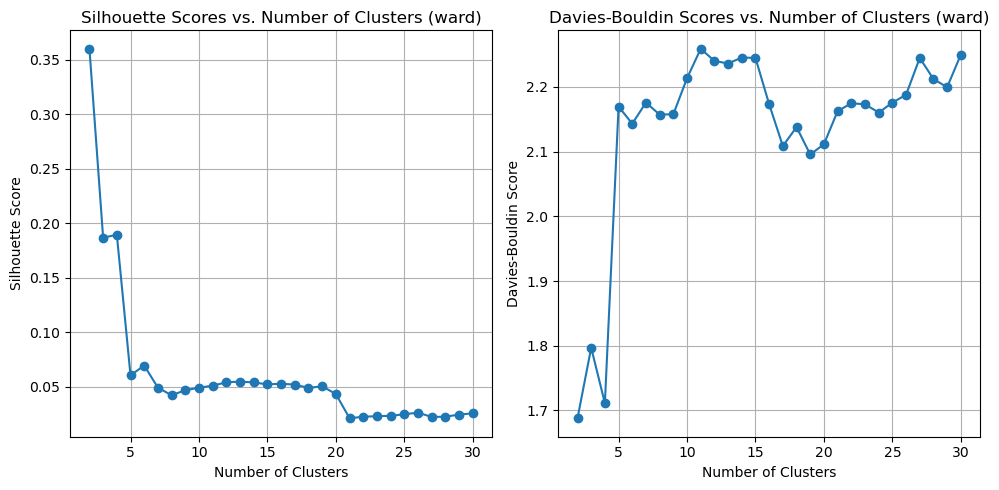

In [33]:
for norm in ['l1','l2','max',None]:
    print(norm)
    Z_ward_test, document_embeddings_norm = create_linkage_matrix(document_embeddings, strategy='ward', norm=norm)
    print(pd.DataFrame(pd.Series(np.ravel(document_embeddings_norm)).describe()).drop('count').T)
    sns.histplot(np.ravel(document_embeddings_norm))
    plt.show()
    test_clusters_agglomerative(document_embeddings_norm, 'ward', cluster_range, Z_ward_test)

In [19]:
Z_ward, document_embeddings = create_linkage_matrix(document_embeddings, 'ward', 'l2')

In [21]:
# Z_ward, document_embeddings = create_linkage_matrix(document_embeddings, strategy='ward')
# test_clusters_agglomerative(document_embeddings, 'ward', cluster_range, Z_ward)

In [22]:
# test_clusters_agglomerative(document_embeddings, 'ward', list(range(2, 100 + 1, 1)), Z_ward)

In [31]:
# cluster_range_2 = [5,10,15,20,25,30,35,40,45,50,55]
cluster_range_2 = cluster_range

# for strategy, z in zip(['single','complete','average','ward'], [Z_single, Z_complete, Z_average, Z_ward]):
# for strategy, z in zip(['single'], [Z_single]):
# for strategy, z in zip(['complete','average','ward'], [Z_complete, Z_average, Z_ward]):
for strategy, z in zip(['ward'], [Z_ward]):
    # print(strategy, Z)
    plot_and_save_dendrograms(document_embeddings, strategy, cluster_range_2, save_dir=os.path.join(f'word2vec tfidf {window} linkage',f'linkage l2 {max_components}',f'denograms_{strategy}'), Z=z)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [04:22<00:00,  9.04s/it]


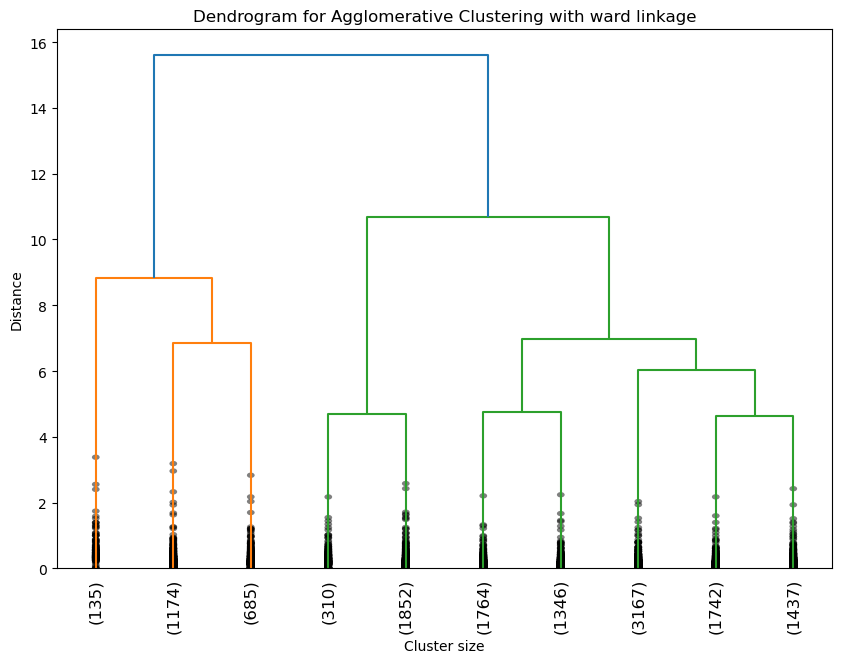

0.0492480779957001 2.213535619892905
8     3167
5     1852
6     1764
9     1742
10    1437
7     1346
2     1174
3      685
4      310
1      135
Name: count, dtype: int64


In [20]:
labels, silhouette_avg, db_score = get_cluster_labels_agglomerative(document_embeddings, 'ward', 10, Z_ward)

In [21]:
labels

array([ 8,  3,  6, ...,  5, 10,  6], dtype=int32)

In [22]:
# Job Title,Company Name,Location,Salary Estimate,Rating,Job Description,Founded,Industry,Revenue,Sector,Size,Type,Easy Apply,Duplicate Count,
# Job Title clean,Salary Type,min_salary,max_salary,job_description_cleaned,Years Experience

## filter stopwords

In [23]:

# from nltk.corpus import stopwords as nltk_stopwords
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

# # Counting the number of stopwords in each set
# nltk_stopwords = set(nltk_stopwords.words('english'))
# sklearn_stopwords = set(sklearn_stop_words)

# nltk_stopwords_count = len(nltk_stopwords)
# sklearn_stopwords_count = len(sklearn_stopwords)

# stopword_sets = dict()
# stopword_sets['no'] = None
# stopword_sets['nltk'] = list(nltk_stopwords)
# stopword_sets['sklearn'] = list(sklearn_stopwords)
# stopword_sets['nltk sklearn union'] = list(nltk_stopwords.union(sklearn_stopwords))
# stopword_sets['nltk sklearn intersect'] = list(nltk_stopwords.intersection(sklearn_stopwords))


In [24]:
# for sw in stopword_sets.keys():
#     if sw != 'no':
#         continue
#     selected_stopwords = stopword_sets[sw]
    
#     for column in ['job_description_cleaned']:
#         for i in [1,2,3,4,5]:
#             ii = (i,i)
#             count_mat, tfidf_mat, feature_names = get_count_and_tfidf_dfs(combined_data, column, CountVectorizer(ngram_range=ii, stop_words=selected_stopwords))
                
#             save_dir = os.path.join('keywords stopwords test',f'keywords word2vec tfidf {window} {len(set(labels))} clusters {sw} stopwords', f'{column}_{len(set(labels))}_{ii[0]}-{ii[1]}')
#             plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir)
#             plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, labels)

## filter with specified vocab

In [25]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

vocab = {
 'ai', 'artificial intelligence', 'aws', 'apache', 'hadoop', 'spark', 'business intelligence','bi','architecture', 'cleaning','processing','interpretation', 'mining', 'modeling', 
 'visualization', 'warehousing', 'database', 'management', 'etl', 'excel','vba', 'google', 'analyze', 'analysis', 'data analysis','java', 'jupyter', 'kafka', 'machine learning', 'ml', 'deep learning',
 'power bi', 'project management', 'python', 'pytorch', 'r', 'redshift', 'reporting', 'sas','spss', 'scala', 'scikit-learn', 'sql', 'nosql',
 'statistical','statistics',  'tableau','looker', 'tensorflow',
 'plotly','linux','oracle','git','dashboard','c#','c++','matlab','regression','classification','nlp','natural language','computer vision',
 'bachelor','master','phd','computer science','computer engineering','data engineering','mathematics','data science','data analytics','operations','economics','consulting','mba',
 'numpy','matplotlib','scipy','seaborn',
 'javascript','typescript', 'swift', 'ruby', 'rust', 'go', 'net', 'php', 'html', 'dart','apex', 'shell'
}
vocab = set([wordnet_lemmatizer.lemmatize(word) for word in vocab])

In [45]:
for column in ['job_description_cleaned']:
    for i in [1,2,3,4,5]:
        ii = (i,i)
        count_mat, tfidf_mat, feature_names = get_count_and_tfidf_dfs(combined_data, column, CountVectorizer(ngram_range=ii))
            
        save_dir = os.path.join('keywords vocab l2 test regex false',f'keywords word2vec tfidf {window} {max_components} {len(set(labels))} clusters', f'{column}_{len(set(labels))}_{ii[0]}-{ii[1]}')
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, keywords=vocab, regex=False)
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, labels, keywords=vocab, regex=False)

job_description_cleaned (1, 1)
(13612, 42849)
job_description_cleaned (2, 2)
(13612, 758022)
job_description_cleaned (3, 3)
(13612, 2134112)
job_description_cleaned (4, 4)
(13612, 3084365)
job_description_cleaned (5, 5)
(13612, 3512311)


In [29]:
for column in ['Job Title clean','Company Name','Industry','Revenue','Sector','Size','Type','State']:
    for i in [1]:
        ii = (i,i)
        count_mat, tfidf_mat, feature_names = get_count_and_tfidf_dfs(combined_data, column, CountVectorizer(ngram_range=ii, tokenizer=lambda x: [x], lowercase=False))
            
        save_dir = os.path.join('keywords vocab l2 test regex true',f'keywords word2vec tfidf {window} {max_components} {len(set(labels))} clusters', f'{column}_whole_{len(set(labels))}_{ii[0]}-{ii[1]}')
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir)
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, labels)

Job Title clean (1, 1)
(13612, 6159)
Company Name (1, 1)
(13612, 6109)
Industry (1, 1)
(13612, 117)
Revenue (1, 1)
(13612, 13)
Sector (1, 1)
(13612, 26)
Size (1, 1)
(13612, 8)
Type (1, 1)
(13612, 14)
State (1, 1)
(13612, 39)


In [30]:
# combined_data.assign(cluster_assignment=labels)\
#     .to_csv(os.path.join('combined data with labels', f'combined word2vec {len(set(labels))} clusters.csv'),index=False)

observations

- with 25 components, I captured ~11% of the explained variance. the silhoutte and davies-boudin scores are higher, BUT there is a mega-cluster. Initially I thought this wasn't useful. But it's not surprising, since data-centric jobs have many similarities in their job descriptions, regardless if the search query was data scientist, data analyst, data engineer, or business analyst. These 4 queries cover a broad range of job titles but we can conclude that most have similar job descriptions. However using only 25 components means we are missing lots of information.

- with 400 components, I captured ~37% of the explained variance. this is reasonable considering we're using tf-idf data. 
- I may want to do analysis by job title. maybe analyze the closeness of job descriptions under the same job title.
  - x most popular job titles
  - job titles containing certain keywords (e.g. tite contains "AI","ML", "IT", "consultant", "cloud", "SAS", "HR", etc)
  - senior vs junior vs no designation (mid-level)





-

- with 400 components, only ward strategy gives me clusters that make sense. for the other strategies, clusters split off from the same mega-cluster
  - score graphs between single and average are somewhat similar. couldnt print out the single strategy denogram due to max recursion error causing my kernel to crash
- thus I committed to using ward.
- At 19 clusters is a local maxima in silhoutte score, and a near-local minima in davis boudin score. So I first exported the labels at 19 clusters for analysis.

- I tuned clustering using decomposition instead of adjusting the min_df/max_df of vectorizers because I expected the effects to be smoother.

- my previous method (only used truncatesvd on the unfiltered data). if i stick with 400 components but clean up the vocab so that the zipf graph is more linear, that means i would be capturing more variance with less noise
  - By cleaning up the vocabulary before applying TruncatedSVD, I would be capturing more of the meaningful variance, which can be thought of as the "signal" amidst the "noise" of less informative terms.

